### | Automatic Ticket Classification Assignment |

### Preparer : Swati Banerjee

### Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.


### Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

### Importing the libraries

In [1]:
import json 
import collections
#
import numpy as np
import pandas as pd
import re, nltk, spacy, string
#
import en_core_web_sm
nlp = en_core_web_sm.load()
#
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
#
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
#
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
#
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
#
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#
from pprint import pprint
import swifter
import tqdm

### Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints.json')
# returns JSON object as  
# a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

### Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

In [4]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#Assign new column names

In [8]:
new_col_names = [column_name.lstrip('_').split('.')[-1] for column_name in df.columns]
new_col_names

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [9]:
columns=dict(zip(df.columns, new_col_names))
df.rename(columns=columns,inplace=True)

In [10]:
# check column names after update

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [12]:
#Assign nan in place of blanks in the complaints column

In [13]:
df['complaint'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)
df.drop(columns=['complaint_what_happened'], inplace=True)

In [14]:
df['complaint']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint, Length: 78313, dtype: object

In [15]:
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,sub_issue,consumer_consent_provided,complaint
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,Debt is not yours,Consent not provided,NaN
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Didn't receive enough information to verify debt,Consent provided,Good morning my name is XXXX XXXX and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,Problem with rewards from credit card,Consent provided,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,None,Consent not provided,NaN
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,Charged too much interest,N/A,NaN


In [16]:
df.shape

(78313, 22)

In [17]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])

In [18]:
# verify how many rows are dropped
df.shape

(21072, 22)

In [19]:
df['complaint'].head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [20]:
# Write your function here to clean the text and remove all the unnecessary elements.
def pre_process(text):
    
    # convert to lower
    text = text.lower()
    
    # remove text in sq. bracket
    # search and remove text within square brackets followed by zero or more spaces
    # use non-greedy matching to match all square brackets separately
    text = re.sub("\[.*?\]\s*", "", text)
    
    # remove punc.
    # create a translation table to remove all punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove words with nos.
    # search and remove digits surrounded by 0 or more alphanumeric chars followed by zero or more spaces
    text = re.sub("\w*\d+\w*\s*", "", text)
    
    return text

In [21]:
#Write your function to Lemmatize the texts

In [22]:
lemmatizer = WordNetLemmatizer()

def apply_lemma(pre_processed_text):
    # tokenize
    tokens = word_tokenize(pre_processed_text)
    
    # lemmatize 
    lemmatized_tokens = []
    for token, tag in pos_tag(tokens):
        lemmatized_word = lemmatizer.lemmatize(token, get_wordnet_pos(tag))
        lemmatized_tokens.append(lemmatized_word)
        
    return " ".join(lemmatized_tokens)

def get_wordnet_pos(treebank_tag):
    """
    helper method to translate treebank tag to wordnet tags,
    as required by lemmatize method
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # default to noun as that is the default in lemmatize method too
        return wordnet.NOUN

In [23]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Avijit
[nltk_data]     Chakraborty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Avijit
[nltk_data]     Chakraborty\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Avijit
[nltk_data]     Chakraborty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

In [25]:
df_clean = pd.DataFrame()

In [26]:
df_clean['complaint'] = df.complaint.swifter.apply(pre_process)
df_clean['lemmatized_complaint'] = df_clean.complaint.swifter.apply(apply_lemma)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [27]:
df_clean.head()

,complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [28]:
#Write your function to extract the POS tags 

In [29]:
model = spacy.load("en_core_web_sm")
#
def extract_POS_tags(pre_processed_text):
    # extract NOUN POS, ignore all other POS
    nouns = []
    doc = model(pre_processed_text)
    for tok in doc:
        if tok.pos_ in ["NOUN", "PROPN"]:
            nouns.append(tok.text)

    return " ".join(nouns)

In [30]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

In [31]:
df_clean['extracted_complaint'] = df_clean.complaint.swifter.apply(extract_POS_tags)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [32]:
df_clean.sample(10)

,complaint,lemmatized_complaint,extracted_complaint
47443,i was the victim of grand larceny by false pre...,i be the victim of grand larceny by false pret...,victim larceny pretenses country complaint xxx...
30228,on xxxx i went to my local chase bank to withd...,on xxxx i go to my local chase bank to withdra...,xxxx chase bank money atm funds parking lot ph...
21251,i have a xxxx account with no incoming interna...,i have a xxxx account with no incoming interna...,account wire fee chase wire fee fee contact ch...
20319,to whom it may concern i would like to appeal ...,to whom it may concern i would like to appeal ...,chase banks decision xxxxxxxx chase letter xxx...
62004,i have purchased xxxx from a vendor on they in...,i have purchase xxxx from a vendor on they inv...,xxxx vendor amount vendor charge amounts credi...
61172,due to identify theft i feel behind on my loan...,due to identify theft i feel behind on my loan...,theft loan payments auto finance order assets ...
40046,i applied for the chase xxxx mileage plus club...,i apply for the chase xxxx mileage plus club c...,chase xxxx mileage club card xxxxxxxx time web...
65091,hello i signed up for automatic payment in xxx...,hello i sign up for automatic payment in xxxxx...,payment xxxxxxxx chase credit card bank accoun...
70664,hi i find chase freedom practice to be in viol...,hi i find chase freedom practice to be in viol...,chase freedom practice violation udaap piece c...
39845,today i had a very strange conversation with ...,today i have a very strange conversation with ...,today conversation chase offices xxxx problems...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<AxesSubplot:title={'center':'Complaints distribution by length'}, xlabel='length of complaint', ylabel='Frequency'>

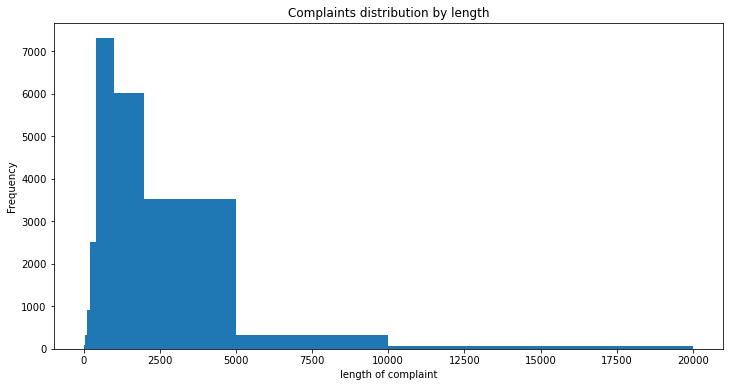

In [33]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.xlabel("length of complaint")
plt.ylabel("frequency")
plt.title("Complaints distribution by length")
#
df_clean['complaint'].str.len().plot(kind='hist', 
                                     bins=[20,50,100,200,400,1000,2000,5000,10000,20000],
                                     figsize=(12,6))

#### Find the top 40 words by frequency among all the articles after processing the text.

In [34]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text

In [35]:
all_complaints = ' '.join(df_clean['extracted_complaint'])
all_complaints = re.sub("x{2,}", "x", all_complaints)

In [36]:
stopwords = STOPWORDS
stopwords.add('x')
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=40).generate(all_complaints)

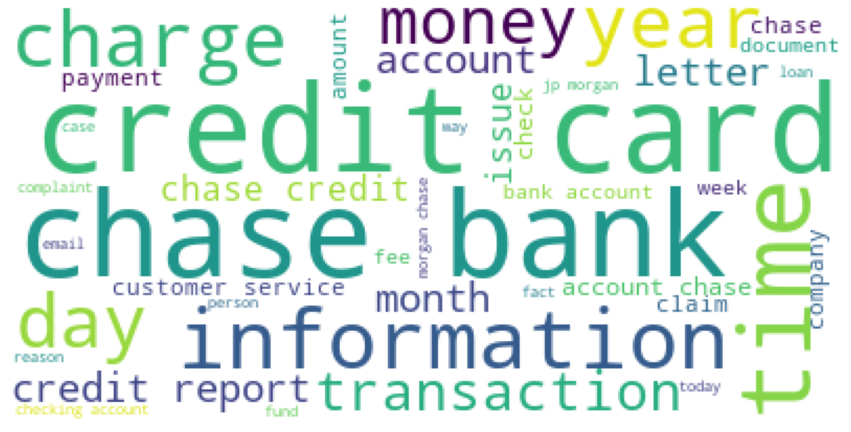

In [37]:
rcParams['figure.figsize'] = 15, 15
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [38]:
# print top 40 words

In [39]:
wordcloud.words_

{'credit card': 1.0,
 'chase bank': 0.9501557632398754,
 'time': 0.6579439252336449,
 'information': 0.4260903426791277,
 'charge': 0.42118380062305294,
 'year': 0.3912772585669782,
 'day': 0.3611370716510903,
 'money': 0.33574766355140184,
 'transaction': 0.3031931464174455,
 'credit report': 0.29906542056074764,
 'letter': 0.2979750778816199,
 'month': 0.2841121495327103,
 'account': 0.2832554517133956,
 'chase credit': 0.27764797507788164,
 'issue': 0.2765576323987539,
 'account chase': 0.2749221183800623,
 'check': 0.27414330218068533,
 'amount': 0.24610591900311526,
 'chase': 0.24376947040498442,
 'company': 0.24338006230529596,
 'customer service': 0.23925233644859814,
 'payment': 0.22009345794392524,
 'claim': 0.21799065420560748,
 'bank account': 0.2159657320872274,
 'document': 0.215809968847352,
 'week': 0.2072429906542056,
 'fee': 0.202803738317757,
 'checking account': 0.2014018691588785,
 'fund': 0.19929906542056075,
 'way': 0.19447040498442367,
 'morgan chase': 0.19236760

In [40]:
# count no. of occurences of each of top 40 words in the corpus

In [41]:
words = []
counts = []
for word in wordcloud.words_:
    words.append(word)
    counts.append(all_complaints.count(word))

In [42]:
# put it in a dataframe and sort
word_counts = pd.DataFrame({'word': words, 'count': counts})
word_counts= word_counts.sort_values(by=['count'])

In [43]:
# plot top 40 words and their count

<BarContainer object of 40 artists>

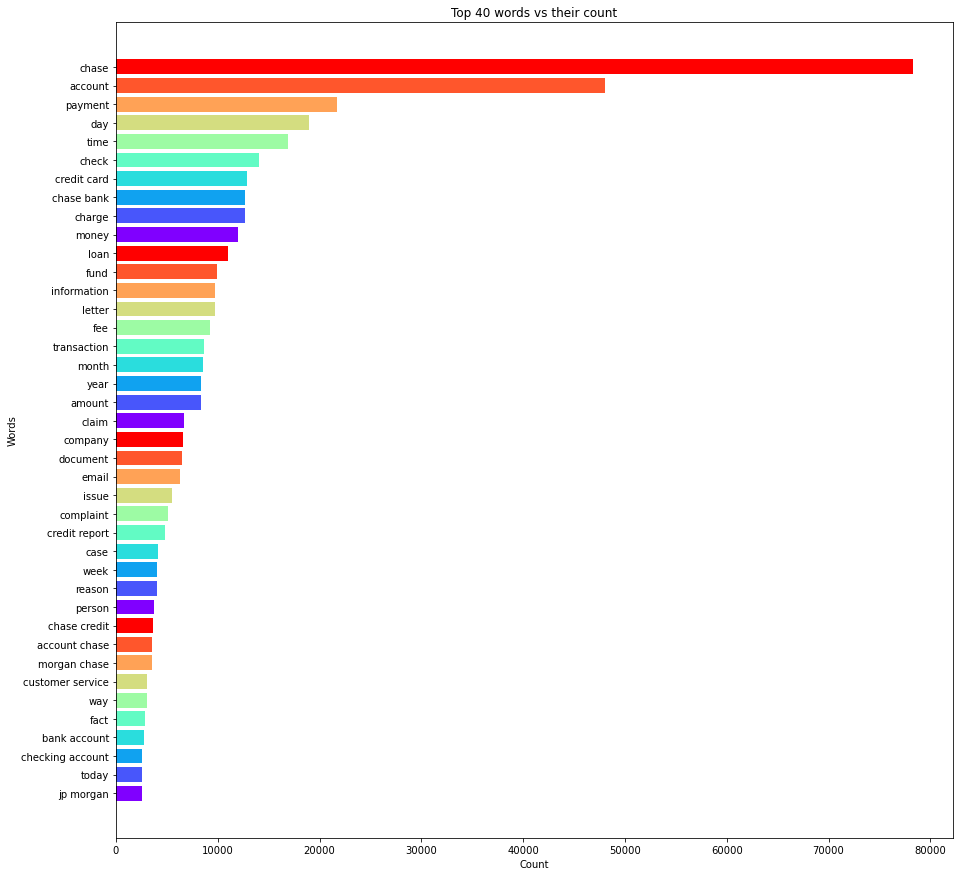

In [44]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 15, 15
plt.title('Top 40 words vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(word_counts['word'], word_counts['count'], color=colors)  

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [45]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

In [46]:
import nltk, re, string, collections
from nltk.util import ngrams
#
# replace previously converted 'x' by empty string
all_complaints = all_complaints.replace('x','')
#
tokenized = all_complaints.split()
unigrams = ngrams(tokenized, 1)
#
unigrams_freq = collections.Counter(unigrams)

In [47]:
# print top 30 unigrams along with their counts

In [48]:
for word_tup in unigrams_freq.most_common(30):
  print(f"{word_tup[0][0]}: {word_tup[1]}")

chase: 72967
account: 41874
credit: 32236
card: 26820
bank: 26421
payment: 13964
time: 11967
money: 11937
loan: 9990
information: 9642
letter: 8420
check: 8349
mortgage: 7932
number: 7756
amount: 7595
phone: 7481
days: 7466
payments: 7198
balance: 7164
fraud: 6990
funds: 6706
company: 6491
charges: 6444
customer: 6438
report: 5999
charge: 5670
accounts: 5654
day: 5517
business: 5455
service: 5373


In [49]:
#Print the top 10 words in the unigram frequency

In [50]:
for word_tup in unigrams_freq.most_common(10):
  print(f"{word_tup[0][0]}: {word_tup[1]}")

chase: 72967
account: 41874
credit: 32236
card: 26820
bank: 26421
payment: 13964
time: 11967
money: 11937
loan: 9990
information: 9642


In [51]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

In [52]:
bigrams = ngrams(tokenized, 2)
bigrams_freq = collections.Counter(bigrams)

In [53]:
# print top 30 bigrams along with their counts

In [54]:
for word_tup in bigrams_freq.most_common(30):
  print(f"{word_tup[0]}: {word_tup[1]}")

('chase', 'bank'): 12102
('credit', 'card'): 10963
('account', 'chase'): 3934
('chase', 'credit'): 3727
('credit', 'report'): 3252
('chase', 'account'): 3051
('customer', 'service'): 3027
('bank', 'account'): 2550
('checking', 'account'): 2504
('morgan', 'chase'): 2465
('jp', 'morgan'): 2439
('account', 'account'): 2081
('card', 'chase'): 1982
('debit', 'card'): 1926
('credit', 'cards'): 1884
('chase', 'card'): 1784
('chase', 'chase'): 1619
('credit', 'score'): 1599
('letter', 'chase'): 1335
('money', 'account'): 1311
('card', 'account'): 1290
('account', 'credit'): 1242
('bank', 'chase'): 1207
('chase', 'mortgage'): 1154
('phone', 'number'): 1135
('i', 'd'): 1093
('interest', 'rate'): 1069
('account', 'number'): 1053
('fraud', 'department'): 1049
('jpmorgan', 'chase'): 1032


In [55]:
#Print the top 10 words in the bigram frequency

In [56]:
for word_tup in bigrams_freq.most_common(10):
  print(f"{word_tup[0]}: {word_tup[1]}")

('chase', 'bank'): 12102
('credit', 'card'): 10963
('account', 'chase'): 3934
('chase', 'credit'): 3727
('credit', 'report'): 3252
('chase', 'account'): 3051
('customer', 'service'): 3027
('bank', 'account'): 2550
('checking', 'account'): 2504
('morgan', 'chase'): 2465


In [57]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

In [58]:
trigrams = ngrams(tokenized, 3)
trigrams_freq = collections.Counter(trigrams)

In [59]:
# print top 30 trigrams along with their counts

In [60]:
for word_tup in trigrams_freq.most_common(30):
  print(f"{word_tup[0]}: {word_tup[1]}")

('chase', 'credit', 'card'): 2238
('jp', 'morgan', 'chase'): 2057
('account', 'chase', 'bank'): 888
('credit', 'card', 'chase'): 882
('chase', 'bank', 'account'): 841
('credit', 'card', 'company'): 799
('credit', 'card', 'account'): 750
('morgan', 'chase', 'bank'): 677
('chase', 'bank', 'credit'): 505
('chase', 'bank', 'chase'): 432
('credit', 'card', 'credit'): 429
('checking', 'account', 'chase'): 426
('card', 'chase', 'bank'): 385
('jpmorgan', 'chase', 'bank'): 376
('chase', 'credit', 'cards'): 354
('bank', 'chase', 'bank'): 348
('credit', 'reporting', 'act'): 340
('bank', 'credit', 'card'): 326
('card', 'credit', 'card'): 323
('credit', 'report', 'chase'): 314
('account', 'credit', 'card'): 313
('credit', 'report', 'credit'): 313
('inquiry', 'credit', 'report'): 307
('account', 'chase', 'account'): 300
('credit', 'reporting', 'agencies'): 295
('chase', 'auto', 'finance'): 287
('chase', 'card', 'services'): 275
('chase', 'account', 'chase'): 273
('customer', 'service', 'representati

In [61]:
#Print the top 10 words in the trigram frequency

In [62]:
for word_tup in trigrams_freq.most_common(10):
  print(f"{word_tup[0]}: {word_tup[1]}")

('chase', 'credit', 'card'): 2238
('jp', 'morgan', 'chase'): 2057
('account', 'chase', 'bank'): 888
('credit', 'card', 'chase'): 882
('chase', 'bank', 'account'): 841
('credit', 'card', 'company'): 799
('credit', 'card', 'account'): 750
('morgan', 'chase', 'bank'): 677
('chase', 'bank', 'credit'): 505
('chase', 'bank', 'chase'): 432


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [63]:
# replace xx..x by empty string

In [64]:
df_clean['complaint'] = df_clean['complaint'].str.replace(r'x{2,}', '', regex=True)
df_clean['lemmatized_complaint'] = df_clean['lemmatized_complaint'].str.replace(r'x{2,}', '', regex=True)
df_clean['extracted_complaint'] = df_clean['extracted_complaint'].str.replace(r'x{2,}', '', regex=True)

In [65]:
df_clean.shape

(21072, 3)

In [66]:
#All masked texts has been removed

In [67]:
df_clean.head()

,complaint,lemmatized_complaint,extracted_complaint
1,good morning my name is and i appreciate it ...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services d...
2,i upgraded my card in and was told by the ag...,i upgrade my card in and be tell by the agen...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...
11,on while trying to book a ticket i came ac...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information ...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [68]:
#Write your code here to initialise the TfidfVectorizer 

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [70]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

In [71]:
tfidf_wm = tfidfvectorizer.fit_transform(df_clean['complaint'])
tfidf_wm.shape

(21072, 15710)

In [72]:
tfidf_tokens = tfidfvectorizer.get_feature_names()

In [73]:
import random
random.sample(tfidf_tokens, 10)

['risen',
 'chart',
 'examining',
 'stateside',
 'video',
 'accomplish',
 'trough',
 'tol',
 'corroborating',
 'neverending']

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [74]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [75]:
#Load your nmf_model with the n_components i.e 5

In [76]:
num_topics = 10 #write the value you want to test out

In [77]:
#keep the random_state =40

In [78]:
nmf_model = NMF(n_components=num_topics, random_state=40)
W = nmf_model.fit_transform(tfidf_wm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [79]:
W.shape, H.shape

((21072, 10), (10, 15710))

In [80]:
#Print the Top15 words for each of the topics

In [81]:
words = np.array(tfidfvectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,money,bank,told,said,called,nt,did,went,asked,help,number,branch,phone,atm,know
Topic 2,card,credit,chase,cards,applied,points,score,limit,offer,closed,application,use,used,new,amazon
Topic 3,loan,mortgage,chase,modification,home,property,foreclosure,payments,years,rate,house,jp,morgan,sale,escrow
Topic 4,account,closed,chase,checking,accounts,bank,opened,open,close,savings,funds,reason,business,access,branch
Topic 5,payment,late,payments,month,paid,pay,credit,auto,make,days,chase,monthly,time,reported,statement
Topic 6,check,funds,deposited,bank,deposit,chase,checks,cashed,cleared,hold,available,cash,days,branch,returned
Topic 7,charges,fraud,fraudulent,transactions,card,claim,transaction,charge,unauthorized,chase,debit,police,department,stolen,reported
Topic 8,balance,fee,fees,charged,overdraft,paid,charge,annual,pay,transfer,statement,account,month,charging,insufficient
Topic 9,dispute,chase,merchant,letter,charge,received,information,refund,sent,email,provided,response,company,did,contacted
Topic 10,credit,report,inquiry,inquiries,hard,reporting,jpmcb,removed,debt,remove,reports,information,bureaus,identity,add


In [82]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

In [83]:
W_df = pd.DataFrame(W, columns=[num for num in range(num_topics)])
W_df['Topic'] = W_df.apply(lambda x: x.idxmax(), axis=1)
W_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,Topic
10496,0.011933,0.027100,0.000000,0.049787,0.082327,0.000000,0.007755,0.025775,0.000000,0.000000,4
14687,0.015951,0.001283,0.050067,0.000000,0.001536,0.000000,0.000000,0.020678,0.000000,0.001390,2
8958,0.013338,0.000000,0.000000,0.033051,0.087386,0.014698,0.000000,0.000000,0.010166,0.000000,4
4006,0.010990,0.000000,0.026466,0.000584,0.000703,0.001913,0.012866,0.001990,0.008242,0.000898,2
9503,0.034980,0.000000,0.008866,0.040345,0.000000,0.001010,0.000000,0.004750,0.003532,0.000000,3
17271,0.007681,0.001859,0.006766,0.066635,0.004732,0.107368,0.001429,0.003368,0.029125,0.000000,5
16897,0.005534,0.000000,0.039946,0.001713,0.000000,0.000000,0.008230,0.000000,0.019954,0.001858,2
2469,0.001193,0.040897,0.005463,0.010740,0.002250,0.001756,0.000000,0.041211,0.031276,0.010556,7
4159,0.000000,0.002647,0.076903,0.000382,0.000000,0.000086,0.000000,0.000000,0.020301,0.000340,2
19469,0.037553,0.029760,0.003202,0.017298,0.000000,0.001943,0.018426,0.000000,0.028859,0.000000,0


In [84]:
# verify no. of rows in W_df 

In [85]:
W_df.shape, df_clean.shape

((21072, 11), (21072, 3))

In [86]:
#Assign the best topic to each of the cmplaints in Topic Column

In [87]:
# Reindex df_clean 
df_clean.reset_index(inplace=True)
df_clean['Topic'] = W_df['Topic']
df_clean.head(10)

,index,complaint,lemmatized_complaint,extracted_complaint,Topic
0,1,good morning my name is and i appreciate it ...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services d...,8
1,2,i upgraded my card in and was told by the ag...,i upgrade my card in and be tell by the agen...,card agent anniversary date agent information ...,1
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,6
3,11,on while trying to book a ticket i came ac...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information ...,1
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,5
5,15,can you please remove inquiry,can you please remove inquiry,inquiry,9
6,17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,3
7,20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer months decline income employment month ...,4
8,21,on i made a payment to an online retailer usi...,on i make a payment to an online retailer use...,payment retailer chase pay chase website sca...,8
9,23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card data credit report company i...,9


In [88]:
#Print the 5 Complaint for each of the Topics

In [89]:
df_clean_top5=df_clean.groupby('Topic')

In [90]:
df_clean_top5.head()

,index,complaint,lemmatized_complaint,extracted_complaint,Topic
0,1,good morning my name is and i appreciate it ...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services d...,8
1,2,i upgraded my card in and was told by the ag...,i upgrade my card in and be tell by the agen...,card agent anniversary date agent information ...,1
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,6
3,11,on while trying to book a ticket i came ac...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information ...,1
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,5
5,15,can you please remove inquiry,can you please remove inquiry,inquiry,9
6,17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,3
7,20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer months decline income employment month ...,4
8,21,on i made a payment to an online retailer usi...,on i make a payment to an online retailer use...,payment retailer chase pay chase website sca...,8
9,23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card data credit report company i...,9


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [91]:
#Create the dictionary of Topic names and Topics

In [92]:
Topic_names = {
    0: 'Others',
    1: 'Credit Card/Prepaid Card',
    2: 'Mortgages/loans',
    3: 'Banking account services',
    4: 'Credit Card/Prepaid Card',
    5: 'Others',
    6: 'Theft/Dispute reporting',
    7: 'Banking account services',
    8: 'Theft/Dispute reporting',
    9: 'Others'
}

In [93]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [94]:
df_clean

,index,complaint,lemmatized_complaint,extracted_complaint,Topic
0,1,good morning my name is and i appreciate it ...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services d...,Theft/Dispute reporting
1,2,i upgraded my card in and was told by the ag...,i upgrade my card in and be tell by the agen...,card agent anniversary date agent information ...,Credit Card/Prepaid Card
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,Theft/Dispute reporting
3,11,on while trying to book a ticket i came ac...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information ...,Credit Card/Prepaid Card
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,Others
...,...,...,...,...,...
21067,78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitations credi...,Credit Card/Prepaid Card
21068,78309,on wednesday i called chas my visa credit c...,on wednesday i call chas my visa credit car...,wednesday chas visa credit card provider clai...,Theft/Dispute reporting
21069,78310,i am not familiar with pay and did not unders...,i be not familiar with pay and do not underst...,pay risk consumers chase bank app chase years ...,Theft/Dispute reporting
21070,78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...,credit yrs chase credit cards chase freedom p...,Banking account services


In [95]:
print(df_clean.groupby('Topic').size())

Topic
Banking account services    3541
Credit Card/Prepaid Card    4600
Mortgages/loans             3112
Others                      5061
Theft/Dispute reporting     4758
dtype: int64


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [96]:
#Create the dictionary again of Topic names and Topics

In [97]:
Topic_numbers = {
    "Banking account services": 0,
    "Credit Card/Prepaid Card": 1,
    "Mortgages/loans": 2,
    "Theft/Dispute reporting": 3,
    "Others": 4,
    }

In [98]:
#Add column for Topic numbers
df_clean['topic_num'] = df_clean['Topic'].map(Topic_numbers)

In [99]:
df_clean

,index,complaint,lemmatized_complaint,extracted_complaint,Topic,topic_num
0,1,good morning my name is and i appreciate it ...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services d...,Theft/Dispute reporting,3
1,2,i upgraded my card in and was told by the ag...,i upgrade my card in and be tell by the agen...,card agent anniversary date agent information ...,Credit Card/Prepaid Card,1
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,Theft/Dispute reporting,3
3,11,on while trying to book a ticket i came ac...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information ...,Credit Card/Prepaid Card,1
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,Others,4
...,...,...,...,...,...,...
21067,78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitations credi...,Credit Card/Prepaid Card,1
21068,78309,on wednesday i called chas my visa credit c...,on wednesday i call chas my visa credit car...,wednesday chas visa credit card provider clai...,Theft/Dispute reporting,3
21069,78310,i am not familiar with pay and did not unders...,i be not familiar with pay and do not underst...,pay risk consumers chase bank app chase years ...,Theft/Dispute reporting,3
21070,78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...,credit yrs chase credit cards chase freedom p...,Banking account services,0


In [100]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

In [101]:
training_data= df_clean[['complaint', 'topic_num']].copy()

In [102]:
training_data['complaint']

0        good morning my name is   and i appreciate it ...
1        i upgraded my   card in and was told by the ag...
2        chase card was reported on however fraudulent ...
3        on while trying to book a     ticket i came ac...
4        my grand son give me check for i deposit it in...
                               ...                        
21067    after being a chase card customer for well ove...
21068    on wednesday  i called chas my   visa credit c...
21069    i am not familiar with  pay and did not unders...
21070    i have had flawless credit for yrs ive had cha...
21071    roughly years ago i closed out my accounts wit...
Name: complaint, Length: 21072, dtype: object

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [103]:
#Write your code to get the Vector count

In [104]:
countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
count_vector = countvectorizer.fit_transform(training_data['complaint'])
count_vector_features = countvectorizer.get_feature_names()
count_vector_features

['aa',
 'aaa',
 'aaaratings',
 'aaccounts',
 'aacount',
 'aaid',
 'aall',
 'aand',
 'aaoa',
 'aare',
 'aarp',
 'aavings',
 'ab',
 'aba',
 'aback',
 'abandon',
 'abandonded',
 'abandoned',
 'abandoning',
 'abandonment',
 'abank',
 'abate',
 'abated',
 'abatement',
 'abbreviation',
 'abc',
 'abd',
 'abe',
 'aberrant',
 'aberration',
 'abet',
 'abets',
 'abetted',
 'abetting',
 'abeyance',
 'abhorred',
 'abhorrent',
 'abhorrently',
 'abide',
 'abided',
 'abiding',
 'abiilities',
 'abilities',
 'ability',
 'abillthe',
 'abject',
 'able',
 'ableto',
 'ablewilling',
 'abnk',
 'abnormal',
 'abnormalities',
 'abnormally',
 'aboard',
 'abolished',
 'abominable',
 'aborad',
 'abort',
 'abou',
 'abounds',
 'abouts',
 'abovea',
 'aboveaverage',
 'abovedescribed',
 'abovementioned',
 'abovenamed',
 'abovereferenced',
 'aboverequested',
 'abovespecifically',
 'abovewas',
 'abovewritten',
 'aboveyou',
 'abrasive',
 'abreast',
 'abroad',
 'abrupt',
 'abruptly',
 'abs',
 'abscond',
 'absconded',
 'absc

In [105]:
# Transform the word vector to tf-idf

In [106]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(count_vector)

In [107]:
transformer.idf_

array([ 8.75847585, 10.95570042,  9.85708814, ..., 10.95570042,
       10.26255324, 10.95570042])

#### Train-Test split

In [108]:
from sklearn.model_selection import train_test_split
X = tfidf
Y = training_data.topic_num.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Write your code here to build any 3 models and evaluate them using the required metrics

### Model 1: Random forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
rf = RandomForestClassifier(n_estimators= 10)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [111]:
y_pred_rf = rf.predict(X_test)

In [112]:
from sklearn.metrics import accuracy_score,classification_report
clf_report = classification_report(y_test,y_pred_rf)
print(clf_report)

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       742
           1       0.66      0.71      0.68       933
           2       0.80      0.87      0.83       603
           3       0.69      0.69      0.69       933
           4       0.69      0.64      0.66      1004

    accuracy                           0.70      4215
   macro avg       0.70      0.71      0.70      4215
weighted avg       0.69      0.70      0.69      4215



In [113]:
rf_acc=accuracy_score(y_test,y_pred_rf) 
rf_acc

0.6951364175563464

### Model 2: Logistic regression

In [114]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga',
                        class_weight='balanced',
                        multi_class='multinomial'
                        )
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='saga')

In [115]:
y_pred_lr = lr.predict(X_test)

In [116]:
clf_report_lr = classification_report(y_test,y_pred_lr)
print(clf_report_lr)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       742
           1       0.90      0.88      0.89       933
           2       0.93      0.98      0.95       603
           3       0.88      0.87      0.88       933
           4       0.89      0.87      0.88      1004

    accuracy                           0.89      4215
   macro avg       0.89      0.89      0.89      4215
weighted avg       0.89      0.89      0.89      4215



In [117]:
log_reg_acc=accuracy_score(y_test,y_pred_lr) 
log_reg_acc

0.8868327402135231

### Model 3: Decision tree

In [118]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [119]:
y_pred_dt = dt.predict(X_test)

In [120]:
clf_report_dt = classification_report(y_test,y_pred_dt)
print(clf_report_dt)

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       742
           1       0.73      0.75      0.74       933
           2       0.82      0.85      0.83       603
           3       0.67      0.67      0.67       933
           4       0.71      0.70      0.71      1004

    accuracy                           0.73      4215
   macro avg       0.74      0.74      0.74      4215
weighted avg       0.73      0.73      0.73      4215



In [121]:
dt_acc=accuracy_score(y_test,y_pred_dt) 
dt_acc

0.7281138790035587

### Model 4: Naive Bayes

In [122]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [123]:
y_pred_nb = nb.predict(X_test)

In [124]:
clf_report_nb = classification_report(y_test,y_pred_nb)
print(clf_report_nb)

              precision    recall  f1-score   support

           0       0.93      0.22      0.36       742
           1       0.66      0.73      0.69       933
           2       0.93      0.76      0.84       603
           3       0.71      0.80      0.75       933
           4       0.59      0.85      0.70      1004

    accuracy                           0.69      4215
   macro avg       0.76      0.67      0.67      4215
weighted avg       0.74      0.69      0.67      4215



In [125]:
nb_acc=accuracy_score(y_test,y_pred_nb) 
nb_acc

0.6906287069988137

### Model Accuracy Comparison

In [126]:
index=['Accuracy']
data = pd.DataFrame({
       'Random Forest':[rf_acc],
       'Logistic Regression':[log_reg_acc],
       'Decision Tree':[dt_acc],          
       'Naive Bayes':[nb_acc]},index=index)
round(data,2)

,Random Forest,Logistic Regression,Decision Tree,Naive Bayes
Accuracy,0.7,0.89,0.73,0.69


### Logistic regression model performs best among other used algorithm, as per accuracy value. 
### We can choose that as our final model